In [50]:
# import necessary libraries 
import pyarrow
import dask as dask
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model, Sequential, load_model

from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Paths

In [3]:
processed_dir = os.path.join( "..", "data", "processed")
final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')
minority_users_autoencoder_csv = os.path.join(processed_dir, 'minority_users_autoencoder.csv')
minority_users_autoencoder_smote_csv = os.path.join(processed_dir, 'minority_users_autoencoder_smote.csv')

Import Dataset

In [24]:
# Read the multi-part Parquet dataset
fds = dd.read_parquet(final_dataset_path)
fds['malicious'] = fds['malicious'].astype(int)
fds.head(4000)

,user,O,C,E,A,N,FCwke,FCowh,FCwh,SDwke,SDowh,SDwh,CDwke,CDowh,CDwh,JDwke,JDowh,JDwh,malicious
0,AAB1302,38,41,10,38,28,23,37,142,0,1,10,0,0,0,40,81,246,0
1,AAB1762,32,39,18,18,33,0,194,654,0,9,14,0,0,4,0,243,679,0
2,AAC0904,31,30,36,18,28,0,0,0,0,22,144,0,5,34,0,499,4025,0
3,AAC1033,42,40,40,22,29,0,0,0,0,14,72,0,0,1,0,1,2,0
4,AAC1489,24,13,42,24,38,0,0,0,0,1,175,0,0,2,0,101,5058,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ZRF1980,43,41,26,16,30,0,9,1272,0,16,298,0,0,11,0,28,494,0
1996,ZUR1449,31,42,12,36,17,0,0,0,0,1,7,0,65,296,0,293,1322,0
1997,ZVW1475,38,35,18,24,37,0,0,0,0,0,1,0,0,0,0,2,7,0
1998,ZWS0755,45,47,42,39,28,0,0,0,0,58,266,0,0,0,0,148,810,0


In [25]:
X = fds.drop(columns = ['user', 'malicious']).compute()
y = fds['malicious'].compute()

# Split the fds into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

print("Train Labels before Resampling")
print(Counter(y_train))

Train Labels before Resampling
Counter({0: 1574, 1: 26})


In [26]:
# transform the dataset
oversample = SMOTE(sampling_strategy=0.4) #sampling_strategy=0.8
resampled_X_train, resampled_y_train = oversample.fit_resample(X_train, y_train)

print("Train Labels after Resampling")
print(Counter(resampled_y_train))

Train Labels after Resampling
Counter({0: 1574, 1: 629})


In [27]:
# Standardize features, using minmax and not standardscale -> got dif??
scaler = MinMaxScaler()
resampled_X_train = scaler.fit_transform(resampled_X_train)
X_test = scaler.transform(X_test)
print(resampled_X_train.shape, X_test.shape)

(2203, 17) (400, 17)


In [28]:
# let model train on normal data only, test using total dataset
train_labels = resampled_y_train.astype(bool)
test_labels = y_test.astype(bool)

normal_train_data = resampled_X_train[train_labels]
normal_test_data = X_test[test_labels]

anomalous_train_data = resampled_X_train[~train_labels]
anomalous_test_data = X_test[~test_labels]

print(normal_train_data.shape, normal_test_data.shape, anomalous_train_data.shape, anomalous_test_data.shape)

(629, 17) (4, 17) (1574, 17) (396, 17)


## Building the model

In [29]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(16, activation='relu'), 
            tf.keras.layers.Dense(8, activation='relu'), # 8 units is the bottleneck layer
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(16, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(17, activation='sigmoid'), # input shape is 17, output shape has to be the same
        ])

        # nonlinear activation

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded    

In [30]:
model = AutoEncoder()  
opt = Adam(learning_rate=0.01)   
model.compile(optimizer = opt, loss = 'mae', metrics = ['mae', 'acc'])

In [31]:
history = model.fit(normal_train_data, normal_train_data,
                    epochs = 50,
                    batch_size = 64,
                    validation_data = (resampled_X_train, resampled_X_train),
                    shuffle = True,
                    #callbacks = [early_stopping]
                    )

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - acc: 0.3452 - loss: 0.3207 - mae: 0.3207 - val_acc: 0.3391 - val_loss: 0.1127 - val_mae: 0.1127
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.4114 - loss: 0.0896 - mae: 0.0896 - val_acc: 0.3391 - val_loss: 0.1024 - val_mae: 0.1024
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.4485 - loss: 0.0774 - mae: 0.0774 - val_acc: 0.3391 - val_loss: 0.0847 - val_mae: 0.0847
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4639 - loss: 0.0672 - mae: 0.0672 - val_acc: 0.3391 - val_loss: 0.0842 - val_mae: 0.0842
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.4818 - loss: 0.0657 - mae: 0.0657 - val_acc: 0.3391 - val_loss: 0.0823 - val_mae: 0.0823
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.4774 - loss: 0.0637 - mae: 0.0637 - val_acc: 0.3391 - val_loss: 0.0837 - val_mae: 0.0837
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.4881 - loss: 0.0615 - mae: 0.0615 - val_acc: 0

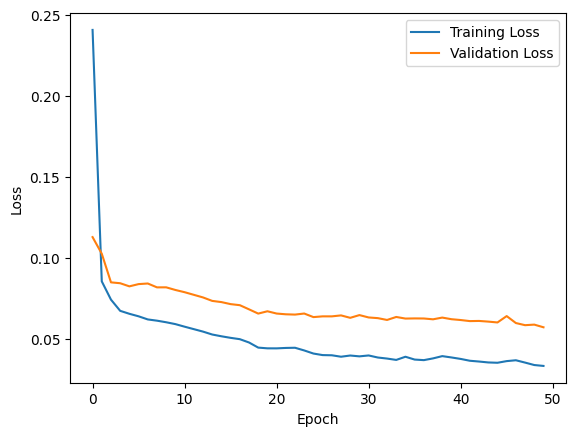

In [32]:
# loss plot
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

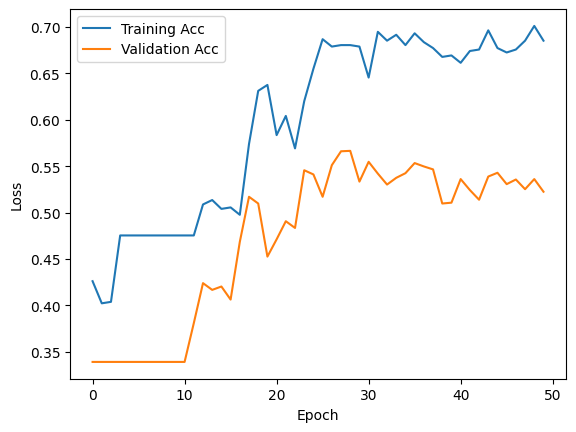

In [33]:
# acc plot
plt.plot(history.history["acc"], label="Training Acc")
plt.plot(history.history["val_acc"], label="Validation Acc")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
test_x_predictions = model.predict(X_test)
print(test_x_predictions.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(400, 17)


In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(resampled_X_train, resampled_y_train)
y_pred = logreg.predict(test_x_predictions)
y_pred_prob = logreg.predict_proba(test_x_predictions)[::,1]

Accuracy = 89.75%
Precision = 0.04878048780487805
Recall = 0.5
f-1 score = 0.08888888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.95       396
           1       0.05      0.50      0.09         4

    accuracy                           0.90       400
   macro avg       0.52      0.70      0.52       400
weighted avg       0.98      0.90      0.94       400



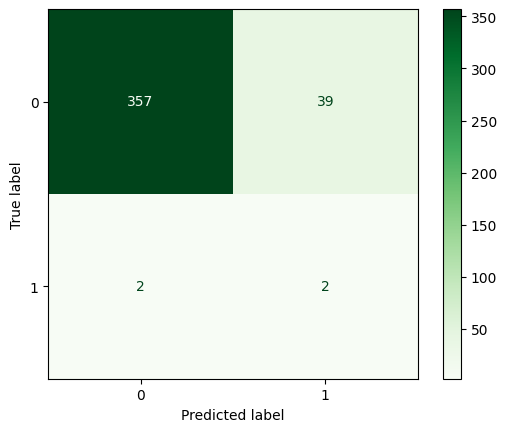

In [36]:
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

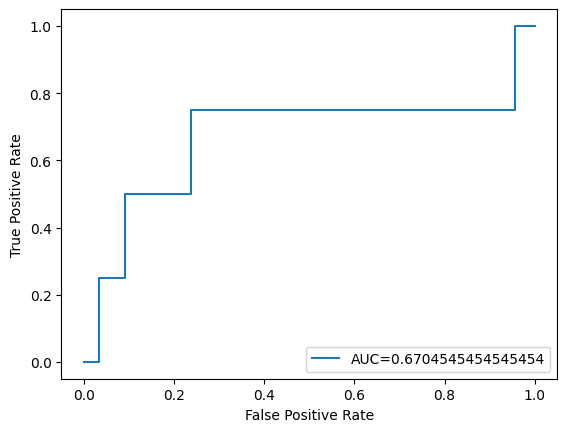

In [37]:
from sklearn import metrics

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prob)
auc = metrics.roc_auc_score(y_test, y_pred_prob)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Identifying True Positives: Malicious users successfuly identified as malicious

In [38]:
# Assuming y_test and y_pred are pandas Series or arrays
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Convert pandas DataFrame to Dask DataFrame
predictions_ddf = dd.from_pandas(predictions_df, npartitions=1)

# Filter true positive instances (predicted_label == 1 and actual_label == 1)
true_positive_ddf = predictions_ddf.loc[(predictions_ddf['predicted_label'] == 1) & (predictions_ddf['actual_label'] == 1)]

# Display true positive instances
print(true_positive_ddf.compute())
print(true_positive_ddf.shape[0].compute())

# Get the indices of true positive as a list
tp_index = true_positive_ddf.index.compute().tolist()
print(tp_index)


      actual_label  predicted_label
1274             1                1
1810             1                1
2.0
[1274, 1810]


In [39]:
# Assuming data is a Dask DataFrame and tn_index is a list of specific row indices
filtered_tp = fds.loc[fds.index.isin(tp_index)]

# Print the filtered DataFrame
print(filtered_tp.compute())
print(filtered_tp.shape[0].compute())

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1274  MCP0611  19  19  19  45  29      0      5   226      0      1    19   
1810  TMT0851  39  39  16  25  25      0     35    77      0      8    20   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1274      0      0     0      0     55    58          1  
1810      0    488  1491      0    311   816          1  
2.0


### Identifying True Negatives: Non-malicious users successfully identified as non-malicious

In [40]:
# Assuming y_test and y_pred are pandas Series or arrays
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Convert pandas DataFrame to Dask DataFrame
predictions_ddf = dd.from_pandas(predictions_df, npartitions=1)

# Filter true negative instances (predicted_label == 0 and actual_label == 0)
true_negative_ddf = predictions_ddf.loc[(predictions_ddf['predicted_label'] == 0) & (predictions_ddf['actual_label'] == 0)]

# Display true negative instances
print(true_negative_ddf.compute())
print(true_negative_ddf.shape[0].compute())

# Get the indices of true negatives as a list
tn_index = true_negative_ddf.index.compute().tolist()
print(tn_index)

      actual_label  predicted_label
23               0                0
30               0                0
32               0                0
44               0                0
45               0                0
...            ...              ...
1966             0                0
1978             0                0
1981             0                0
1987             0                0
1990             0                0

[357 rows x 2 columns]
357.0
[23, 30, 32, 44, 45, 56, 59, 63, 65, 67, 69, 70, 73, 76, 78, 99, 100, 109, 111, 115, 120, 124, 128, 135, 162, 163, 168, 173, 175, 185, 188, 194, 196, 203, 210, 211, 212, 218, 220, 231, 233, 237, 239, 247, 251, 254, 256, 261, 266, 275, 281, 289, 297, 298, 300, 303, 305, 306, 307, 316, 322, 324, 331, 342, 344, 350, 351, 352, 353, 361, 366, 367, 368, 374, 382, 383, 393, 394, 411, 414, 416, 422, 427, 429, 432, 433, 453, 462, 464, 471, 478, 479, 480, 482, 485, 494, 495, 507, 514, 519, 526, 527, 529, 534, 535, 538, 543, 544, 552, 554, 555

In [41]:
# Assuming data is a Dask DataFrame and tn_index is a list of specific row indices
filtered_tn = fds.loc[fds.index.isin(tn_index)]

# Print the filtered DataFrame
print(filtered_tn.compute())
print(filtered_tn.shape[0].compute())

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
23    ACD1174  28  20  38  26  33      0      0     0      0    101   615   
30    ACJ1797  23  32  19  26  32      0      0     0      6      5    15   
32    ACR1045  40  38  10  25  30      0      0     0      0     10    44   
44    AEF1032  25  44  48  18  30      0      0     0      0      0     8   
45    AEG0962  32  36  24  26  35     24      3    97     59      5   118   
...       ...  ..  ..  ..  ..  ..    ...    ...   ...    ...    ...   ...   
1966  YVJ0986  43  48  15  25  23      0      0     0      0      4    64   
1978  ZDH1266  41  44  35  43  29      0      0     0      0      0    13   
1981  ZHB1104  34  14  23  18  31      0      0     0      0      3     3   
1987  ZJT1601  10  50  38  10  35      0     58   213      0    241   793   
1990  ZLM1418  30  18  20  22  26      0      0     0      0      0     4   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
23        0     6

### Identifying False Negatives: Malicious users wrongly identified as non-malicious

In [42]:
# Assuming y_test and y_pred are pandas Series or arrays
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Convert pandas DataFrame to Dask DataFrame
predictions_ddf = dd.from_pandas(predictions_df, npartitions=1)

# Filter false negatives instances (predicted_label == 0 and actual_label == 1)
false_negative_ddf = predictions_ddf.loc[(predictions_ddf['predicted_label'] == 0) & (predictions_ddf['actual_label'] == 1)]

# Display true negative instances
print(false_negative_ddf.compute())
print(false_negative_ddf.shape[0].compute())

# Get the indices of true negatives as a list
fn_index = false_negative_ddf.index.compute().tolist()
print(fn_index)

      actual_label  predicted_label
1473             1                0
1813             1                0
2.0
[1473, 1813]


In [43]:
# Assuming data is a Dask DataFrame and tn_index is a list of specific row indices
filtered_fn = fds.loc[fds.index.isin(fn_index)]

# Print the filtered DataFrame
print(filtered_fn.compute())
print(filtered_fn.shape[0].compute())


         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
1473  OKM1092  11  34  38  15  27      0    105   244      0      0     0   
1813  TNB1616  33  38  10  43  29      0     12    61      0    206   605   

      CDwke  CDowh  CDwh  JDwke  JDowh  JDwh  malicious  
1473      0      1     8      0    108   232          1  
1813      0      9    15      0    123   248          1  
2.0


### Identifying False Positives: Non-malicious users wrogngly identified as nalicious

In [44]:
# Assuming y_test and y_pred are pandas Series or arrays
predictions_df = pd.DataFrame({'actual_label': y_test, 'predicted_label': y_pred})

# Convert pandas DataFrame to Dask DataFrame
predictions_ddf = dd.from_pandas(predictions_df, npartitions=1)

# Filter true negative instances (predicted_label == 1 and actual_label == 0)
false_positive_ddf = predictions_ddf.loc[(predictions_ddf['predicted_label'] == 1) & (predictions_ddf['actual_label'] == 0)]

# Display true negative instances
print(false_positive_ddf.compute())
print(false_positive_ddf.shape[0].compute())

# Get the indices of true negatives as a list
fp_index = false_positive_ddf.index.compute().tolist()
print(fp_index)

      actual_label  predicted_label
29               0                1
49               0                1
123              0                1
270              0                1
354              0                1
438              0                1
450              0                1
530              0                1
581              0                1
602              0                1
613              0                1
654              0                1
670              0                1
746              0                1
874              0                1
886              0                1
889              0                1
937              0                1
973              0                1
990              0                1
993              0                1
1027             0                1
1036             0                1
1054             0                1
1078             0                1
1083             0                1
1179             0          

In [45]:
# Assuming data is a Dask DataFrame and tn_index is a list of specific row indices
filtered_fp = fds.loc[fds.index.isin(fp_index)]

# Print the filtered DataFrame
print(filtered_fp.compute())
print(filtered_fp.shape[0].compute())

         user   O   C   E   A   N  FCwke  FCowh  FCwh  SDwke  SDowh  SDwh  \
29    ACH1840  20  24  15  45  37      0      0     0      0      0   182   
49    AES1373  41  42  19  11  34      0     30  1136      0      7   120   
123   ARB0626  22  20  19  45  34      0     20   945      0     12   122   
270   CAB0290  21  16  14  22  35      0      0     0      0     73   174   
354   CJM0410  17  10  20  42  26      0    324  3662      0      4    32   
438   DAH1996  45  30  13  40  35      0      0     0      0    149   442   
450   DCD0715  38  46  10  50  37      0      0     0      0     57   340   
530   DRN0735  29  23  22  50  28      0      0     0      0     13    51   
581   EJW1544  25  10  41  47  37      0      0     0      0      1     1   
602   ESH1028  35  20  15  36  33      0      0     0    200      1   484   
613   EZB0925  21  24  15  43  26    392   1057   113    384    164   942   
654   GBV0440  31  12  10  44  21      0      4   250      0     11   130   

### using encoder to predict test data
### use predictions as training dataset for logreg classifier
### tune with gridsearchcv and evaluate

In [46]:
# model.encoder
compressed_X_test = model.encoder.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [48]:
# Initialize Logistic Regression classifier
logreg = LogisticRegression()

# Define hyperparameters to tune using GridSearchCV
param_grid = {'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01], 'penalty': ['l2']}

# Initialize GridSearchCV with the classifier and hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=3, scoring='accuracy')

# Fit the classifier using the compressed test data
grid_search.fit(compressed_X_test, y_test)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'penalty': ['l2']},
             scoring='accuracy')

In [49]:
# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

# Use the best classifier to predict on test data
y_pred = best_logreg.predict(compressed_X_test)


Accuracy: 99.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

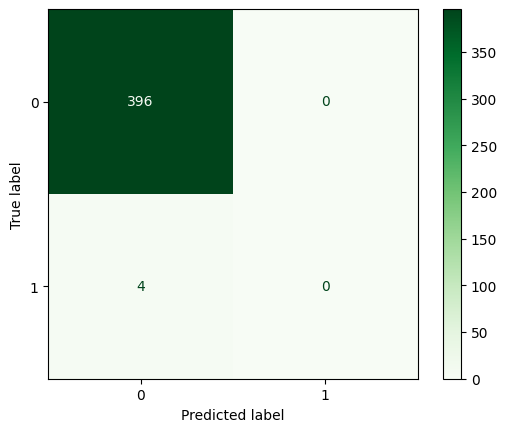

In [52]:
# Evaluate the model
best_logreg.fit(resampled_X_train, resampled_y_train)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Evaluate the classifier using classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

### using entire autoencoder to predict test data
### then use these predictions as a training dataset for a logreg classifier
### tune with gridsearchcv

In [53]:
# Assuming you have an autoencoder model named 'autoencoder_model'
reconstructed_X_test = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [54]:
# Flatten the reconstructed data
flattened_X_test = reconstructed_X_test.reshape(reconstructed_X_test.shape[0], -1)

In [55]:
# Initialize Logistic Regression classifier
logreg = LogisticRegression()

# Define hyperparameters to tune using GridSearchCV
param_grid = {'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01], 'penalty': ['l2']}

# Initialize GridSearchCV with the classifier and hyperparameters
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the classifier using the flattened reconstructed test data
grid_search.fit(flattened_X_test, y_test)


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01],
                         'penalty': ['l2']},
             scoring='accuracy')

In [56]:
# Get the best estimator from GridSearchCV
best_logreg = grid_search.best_estimator_

# Use the best classifier to predict on test data
y_pred = best_logreg.predict(flattened_X_test)

# Evaluate the classifier using classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [57]:
best_logreg

LogisticRegression(C=1e-07)

Accuracy: 99.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       396
           1       0.00      0.00      0.00         4

    accuracy                           0.99       400
   macro avg       0.49      0.50      0.50       400
weighted avg       0.98      0.99      0.99       400



c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

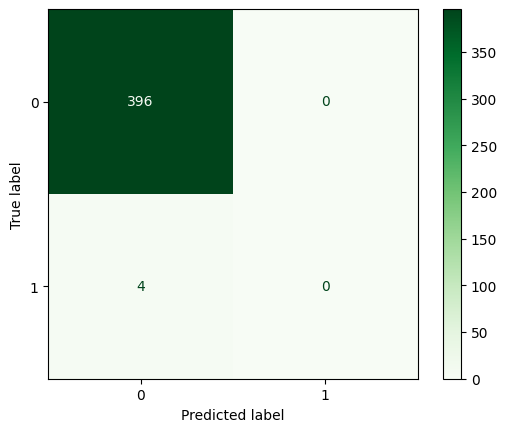

In [58]:
# Evaluate the model
best_logreg.fit(resampled_X_train, resampled_y_train)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Greens)
plt.show()

### feature importance

In [60]:
# Feature Selection
rfe = RFECV(estimator = logreg, scoring = 'precision') #minimises false positives
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)

print('Chosen best features by rfe:', X_train.columns[rfe.support_].tolist())
print('Ranking of Feature Importance:', rfe.ranking_)

c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: 

Chosen best features by rfe: ['N']
Ranking of Feature Importance: [ 2  3  4 16  1 11 10 17 13  7  8 14  9 12  6  5 15]


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


In [61]:
best_logreg = grid_search.best_estimator_

# Use encoder part of the autoencoder for feature selection

encoded_features_train = model.encoder.predict(X_train)
encoded_features_test = model.encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Encoded Features Shape (Train): (1600, 8)
Encoded Features Shape (Test): (400, 8)


In [63]:
# Fit a logistic regression model using the selected features
model = LogisticRegression()
model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred = model.predict(encoded_features_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with Selected Features:", accuracy)

Accuracy with Selected Features: 0.99


<Axes: >

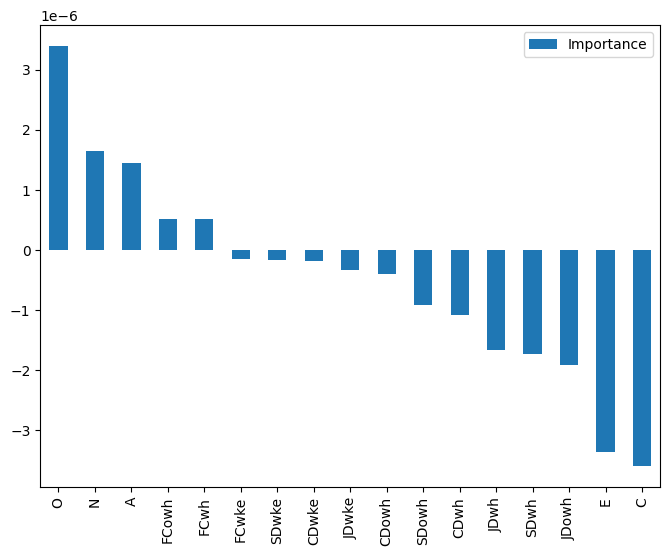

In [64]:
# feature importance
feat_importances = pd.DataFrame(best_logreg.coef_[0], index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

### Risk scores

In [70]:
def get_risk_score(logreg, X):
    def min_max_scaling(value, new_min, new_max):
        old_min = min(value)
        old_max = max(value)
        scaled_value = ((value - old_min) / (old_max - old_min)) * (new_max - new_min) + new_min
        return scaled_value
    
    # distance from decision boundary where negative = non anomaly and positive = anomaly
    distances = logreg.decision_function(X)
    risk_scores = min_max_scaling(distances, 0,1)
    
    return risk_scores

In [71]:
train_risk = get_risk_score(best_logreg, resampled_X_train)
test_risk = get_risk_score(best_logreg, X_test)

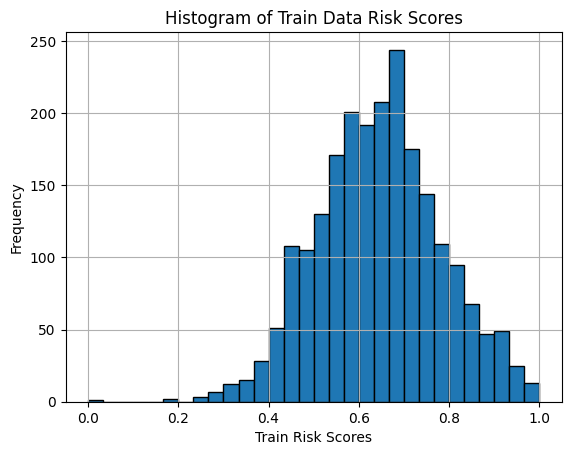

In [72]:
# Plot histogram for train risk score
plt.hist(train_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Train Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Train Confidence Scores')
plt.grid(True)
plt.show()

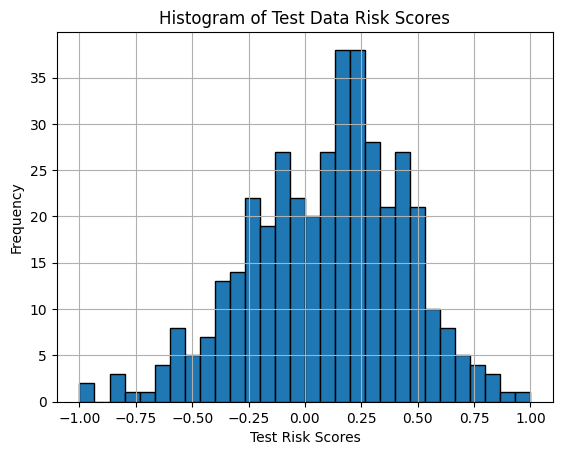

In [68]:
# Plot histogram for test risk score
plt.hist(test_risk, bins=30, edgecolor='black')  # Adjust bins as needed
plt.xlabel('Test Risk Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Test Data Risk Scores')
plt.grid(True)
plt.show()

In [69]:
print("Example Train Risk Scores:")
print(train_risk[:10])  
print("\nExample Test Risk Scores:")
print(test_risk[:10])

Example Train Risk Scores:
[ 0.47820691  0.64129382 -0.02185524  0.35331452  0.48841061  0.17734282
  0.04405213  0.51903072  0.23834907  0.07409668]

Example Test Risk Scores:
[-0.3395799  -0.65249901 -0.05851864  0.28684464  0.26825914  0.50561779
  0.2517187  -0.15773128  0.61265542 -0.3000273 ]


### exporting fn/tn/fp/tp to csv

In [3872]:
# Convert the 'user' column from each Dask DataFrame to a Pandas Series
user_tn = filtered_tn['user'].compute()
user_tp = filtered_tp['user'].compute()
user_fn = filtered_fn['user'].compute()
user_fp = filtered_fp['user'].compute()

# Create a Pandas DataFrame with the 'user' columns from each Dask DataFrame
combined_df = pd.DataFrame({
    'user_tn': user_tn,
    'user_tp': user_tp,
    'user_fn': user_fn,
    'user_fp': user_fp
})

# Export the combined DataFrame to a CSV file
combined_df.to_csv('combined_users.csv', index=False)
